Rock Paper Scissors is a classic hand game where players compete through using hand gestures (see [Wikipedia](https://en.wikipedia.org/wiki/Rock\_paper\_scissors)).  The Tensorflow-datasets package provides a 
library of hand gestures corresponding to allowed gestures in the game.  The original source is a synthetic data source, via Laurence Maroney ([source](https://laurencemoroney.com/datasets.html\#rock-paper-scissors-dataset)).

Write a convolutional neural network (CNN) that classifies these images, i.e., identifies the gesture (rock, paper, scissors) from each source image.  For convenience, this template is provided for loading the dataset and for data augmentation.  Feel free to make any changes to this template code.  Try to achieve a validation accuracy rate of 90\% or above.

You may make use of pretrained CNN architectures in Keras or develop your own.  If you develop your own, you are encouraged to review the network architectures discussed in class (e.g., LeNet and AlexNet).  Because the training dataset
is relatively small, you may need to employ techniques such as regularization and data augmentation to achieve a high accuracy rate.

Using a graphics card is highly recommended.  You can set Colab to use the graphics card in Runtime$\rightarrow$Manage Settings.

#Template

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

We first load the test dataset from tensorflow datasets (TFDS).  The original set has only training and validation sets, so we shuffle the dataset here to produce training, validation, and validation sets.

* [Documentation for `tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)
* [Rock Paper Scissors dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors)
* [TFDS images in this dataset](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=rock_paper_scissors)

In [2]:
(ds_orig, ds_val_orig, ds_test_orig), dsinfo = tfds.load(
    'rock_paper_scissors',
    split=("test+train[60%:]", "train[60%:80%]", "train[80%:]"),
    with_info=True,
    as_supervised=True,
    shuffle_files=False)

labelnames = dsinfo.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete041O9F/rock_paper_scissors-train.tfrecord*…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete041O9F/rock_paper_scissors-test.tfrecord*.…

Dataset rock_paper_scissors downloaded and prepared to ~/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


Below are constants, configure as needed.

In [34]:
batch_size = 8   # size of mini-batch
image_size = 64  # size of image to feed into network
n_repeat = 5 # number of times to repeat the input dataset with distorted images

We create a convenience function, `show_sample_images` to show 10 random images from the set.  Example usage: `show_sample_images(ds_orig)`.

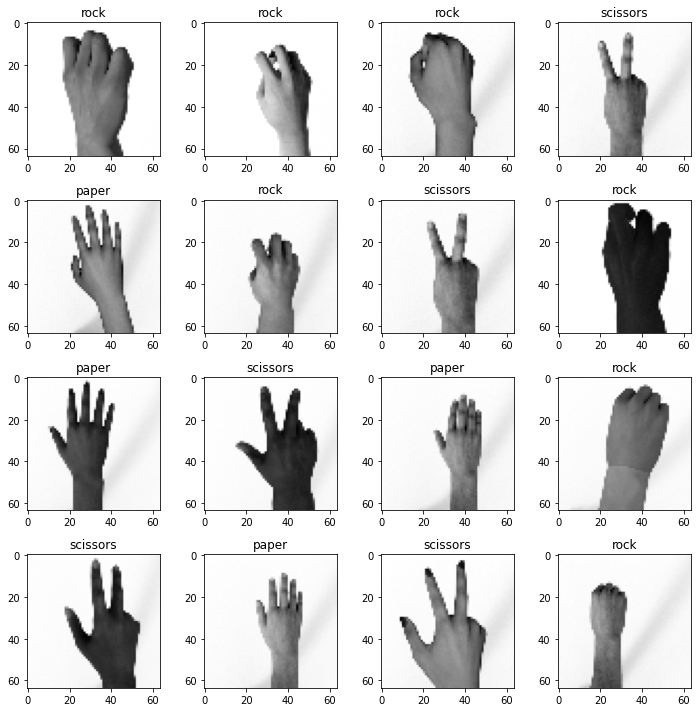

In [54]:
def show_sample_images(ds):
  fig, axs = plt.subplots(4, 4, figsize=(10,10))
  for ax, k in zip(np.array(axs).ravel(), ds.unbatch().shuffle(128).take(16)):
      ax.imshow(k[0].numpy().reshape(image_size, image_size), cmap='gray')
      ax.set_title(labelnames[k[1]])
  fig.tight_layout()

show_sample_images(ds)

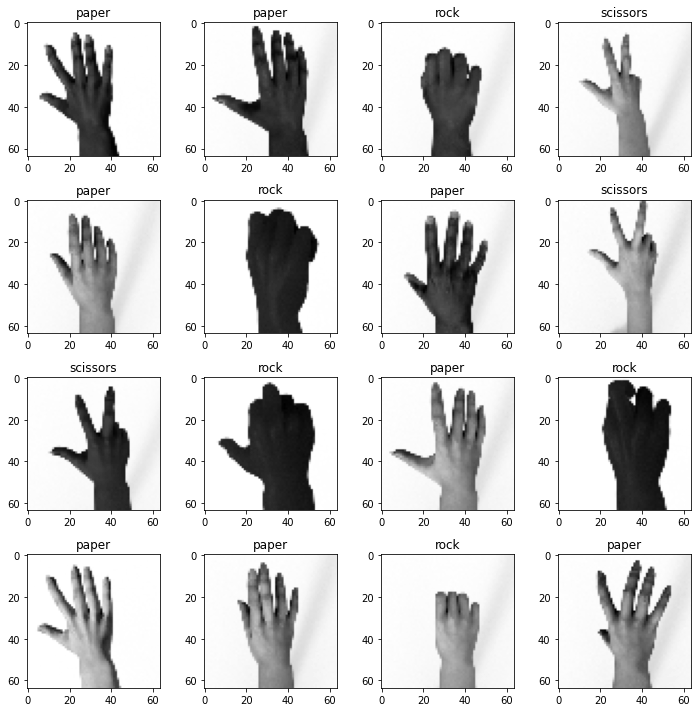

In [53]:

show_sample_images(ds_val)

We will need to perform some preprocessing.  The below preprocessing function is a starting point.

* `distort` is a network that performs image augmentation.  For input images, it will randomly provide distortions such as distorting contrast, zooming in or out, rotation, and translation.  Passing an image into this network will apply these distortions.  Refer to documentation for these functions [here](https://www.tensorflow.org/api_docs/python/tf/image).

* `preproc` is a preprocessing function that accepts an image and label, and can apply updates to both (similar to a FunctionTransformer in scikit).  We only apply distortions if augment is true (as we will see, we want to apply to the training dataset).  

   Preproc also converts the image to grayscale, which provides some performance improvement since color is not expected important for processing.  If you remove grayscale conversion, remember to change the depth of the input layer from 1 to 3.

  Finally, preproc rescales the image from 0-255 to 0-1 ([`convert_image_dtype`](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype)) and resizes the image.

  * We also create two wrapper functions, `preproc_no_distort` and `preproc_distort`, for later compatibility with the tensor flow's data object.

In [64]:
distort = keras.Sequential(
    [
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomZoom((-.05, .05), fill_mode='nearest'),
    keras.layers.RandomRotation((-.04, .04), fill_mode='nearest'),
    keras.layers.RandomTranslation(0, (-.2, .2), fill_mode='nearest')
    ]
)
def preproc(image, label, augment):
  if augment:
    image = distort(image)/255.0
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (image_size, image_size))
  return image, label

def preproc_no_distort(image, label):
  return preproc(image, label, False)

def preproc_distort(image, label):
  return preproc(image, label, True)

We can now prepare the datasets.  For the three datasets defined above (training, validation, and test), we preprocess each element using the `map` function.  (See [guidelines for TensorFlow input pipelines](https://www.tensorflow.org/guide/data) and [`tf.data.Dataset` documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).  From the texts, see also chapter 13 in Raschka and chapter 11 in Geron.  We also break the training set into minibatches.

You should not need to change this code (although you may want to change the mini-batch size above).

In [65]:
ds = ds_orig.map(preproc_distort).batch(batch_size)
ds_val = ds_val_orig.map(preproc_no_distort).batch(batch_size)
ds_test = ds_test_orig.map(preproc_no_distort).batch(batch_size)

# Build Model

Note: answers will vary significantly here.  To receive credit, answers must use a ConvNet (Conv2D) layer, or load and train a ConvNet architecture (ResNet, LeNet, AlexNet, etc.).

In [66]:
from tensorflow.keras.layers import (Flatten, BatchNormalization, Dense, 
                                     Dropout, InputLayer, MaxPool2D, Conv2D)
regulizer = keras.regularizers.l2(0.1)
model = keras.models.Sequential()
model.add(InputLayer(input_shape=[64, 64, 1]))
for layer in [32, 64, 128]:
  firstlayer = layer==32
  strides = (1,1)
  kernelsize = 5 if firstlayer else 3
  model.add(BatchNormalization())
  model.add(Conv2D(layer,
                                kernelsize, 
                                strides=strides, 
                                activation='elu',
                                kernel_regularizer=regulizer, 
                                bias_regularizer=regulizer,
                                padding="same"))
  model.add(MaxPool2D())

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='elu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=keras.optimizers.Nadam(),
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

# Fit

We have two callbacks#

* `ModelCheckpoint`, which saves the model after each mini-batch.  We set the `save_best_only` parameter so that if the model performance deteriorates, we only keep the weights from the best-performing batch.

* `EarlyStopping`, which stops the model after no improvement for four iterations.

Note that we repeat the dataset here by calling `ds.repeat(n_repeat)`.  Because we are using image augmentation, this allows the network to be trained on multiple variants of each distorted image.

In [67]:
earlystopping = keras.callbacks.EarlyStopping(min_delta=0.005, patience=4)
checkpoint = keras.callbacks.ModelCheckpoint("mdl-rps-eval-gap.h5", save_best_only=True)
dsr = ds.repeat(n_repeat) if n_repeat > 0 else ds
history = model.fit(dsr, validation_data=ds_val, epochs=20,
                    callbacks=[earlystopping, checkpoint])


Epoch 1/20
865/865 [==============================] - 17s 17ms/step - loss: 2.1069 - accuracy: 0.9019 - val_loss: 0.4772 - val_accuracy: 0.9325
Epoch 2/20
865/865 [==============================] - 15s 17ms/step - loss: 0.4960 - accuracy: 0.9323 - val_loss: 0.8611 - val_accuracy: 0.8214
Epoch 3/20
865/865 [==============================] - 14s 17ms/step - loss: 0.5122 - accuracy: 0.9371 - val_loss: 0.8154 - val_accuracy: 0.9028
Epoch 4/20
865/865 [==============================] - 16s 18ms/step - loss: 0.5613 - accuracy: 0.9448 - val_loss: 0.5098 - val_accuracy: 0.9821
Epoch 5/20
865/865 [==============================] - 14s 17ms/step - loss: 0.7705 - accuracy: 0.9377 - val_loss: 0.5929 - val_accuracy: 0.8750


Model is still learning, so let's try a few more iterations.  (Note: the final accuracy is still above 0.99 if we stop here.)

In [68]:
history = model.fit(dsr, validation_data=ds_val, epochs=25,
                    initial_epoch=20,
                    callbacks=[earlystopping, checkpoint])

Epoch 21/25
865/865 [==============================] - 14s 16ms/step - loss: 0.6516 - accuracy: 0.9491 - val_loss: 0.6570 - val_accuracy: 0.9940
Epoch 22/25
865/865 [==============================] - 14s 17ms/step - loss: 0.5810 - accuracy: 0.9477 - val_loss: 0.9962 - val_accuracy: 0.8492
Epoch 23/25
865/865 [==============================] - 14s 16ms/step - loss: 0.5372 - accuracy: 0.9546 - val_loss: 3.2368 - val_accuracy: 0.7242
Epoch 24/25
865/865 [==============================] - 15s 17ms/step - loss: 0.6950 - accuracy: 0.9436 - val_loss: 0.4417 - val_accuracy: 0.9980
Epoch 25/25
865/865 [==============================] - 14s 17ms/step - loss: 0.7205 - accuracy: 0.9536 - val_loss: 0.5187 - val_accuracy: 0.9544


#  Evaluate

We evaluate the best-performing model (saved in the model checkpoint callback) against the test dataset.  Recall that we are looking for an accuracy of 0.9 or above.

In [69]:
model = keras.models.load_model("mdl-rps-eval-gap.h5")
_, accuracy = model.evaluate(ds_test)
print(accuracy)

63/63 [==============================] - 1s 10ms/step - loss: 0.4514 - accuracy: 0.9901
0.9900793433189392
